# Federated Learning across Nodes Training a CNN model

New script to run a CNN-based federated system, where we can vary the inner and outer learning rates

In [1]:
#Imports
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from sklearn import preprocessing
from sklearn import metrics
from keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import random
import csv
import timeit
from timeit import default_timer as timer

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

Functions to deal with splitting of data or creating models. Basically non-interesting functions

In [2]:
def splittingData(x_train,y_train,x_test,y_test,noClients):
    trainLen = len(x_train)
    clientSize = trainLen/noClients
    
    x_train_clients = []
    y_train_clients = []
    x_test_clients = []
    y_test_clients = []
    
    x_train_splits = np.array_split(x_train,noClients)
    y_train_splits = np.array_split(y_train,noClients)
    x_test_splits = np.array_split(x_test,noClients)
    y_test_splits = np.array_split(y_test,noClients)
    
    for i in range(noClients):
        x_train_clients.append(x_train_splits[i])
        y_train_clients.append(y_train_splits[i])
        x_test_clients.append(x_test_splits[i])
        y_test_clients.append(y_test_splits[i])
    
    return x_train_clients, y_train_clients, x_test_clients, y_test_clients

def createModel(iLr):
    #optimizer = tf.keras.optimizers.Adam(learning_rate=iLr)
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    return model

def createZeroWeightCNN(iLr):
    layer1 = [np.zeros(shape = (3,3,3,32), dtype = 'float32'), np.zeros(shape = 32, dtype = 'float32')]
    layer2 = [np.zeros(shape = (3,3,32,64), dtype = 'float32'), np.zeros(shape = 64, dtype = 'float32')]
    layer3 = [np.zeros(shape = (10816,64), dtype = 'float32'), np.zeros(shape = (64), dtype = 'float32')]
    layer4 = [np.zeros(shape = (64,10), dtype = 'float32'), np.zeros(shape = (10), dtype = 'float32')]

    testModel = models.Sequential()
    testModel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    testModel.add(layers.MaxPooling2D((2, 2)))
    testModel.add(layers.Conv2D(64, (3, 3), activation='relu'))
    testModel.add(layers.Flatten())
    testModel.add(layers.Dense(64, activation='relu'))
    testModel.add(layers.Dense(10))
    optimizer = tf.keras.optimizers.Adam(learning_rate=iLr)
    testModel.layers[0].set_weights(layer1)
    testModel.layers[2].set_weights(layer2)
    testModel.layers[4].set_weights(layer3)
    testModel.layers[5].set_weights(layer4)
    testModel.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    return testModel



Federated Functions, where fedAvg now uses a global learning rate by the following equation:
$$
  G^t = G^{t-1} + \dfrac{\eta}{m}\sum_{i=1}^{m}(P_i^t - G^{t-1}).
$$

In [3]:
def McMahanFedAvg(models_,fedModel,numClients,l):
    #setup an array to hold the weights and a null array to hold the summation of weights in the federated system
    layersNums = [0,2,4,5]    
    fedModelWeights = []
    mmSum = []
    for i in layersNums:
        fedModelWeights.append(fedModel.layers[i].weights)
        mmSum.append(fedModel.layers[i].weights)
    
    for i in range(len(layersNums)):
        for j in range(len(models_[0].layers[layersNums[i]].weights)):
            mmSum[i][j] = mmSum[i][j]*0
    
    #Perform the summation
    for n in range(0,numClients):
        count = 0
        for i in layersNums:
            for j in range(len(models_[0].layers[i].weights)):
                mmSum[count][j] = models_[n].layers[i].weights[j] - fedModelWeights[count][j]
            count += 1
    
    #find the new global models parameters
    count = 0
    for i in layersNums:
        for j in range(len(models_[0].layers[i].weights)):
            mmSum[count][j] = (l/numClients)*mmSum[count][j]
            fedModelWeights[count][j] = fedModelWeights[count][j] + mmSum[count][j]
        count += 1
    
    #Update the global model
    count = 0
    for i in layersNums:
        fedModel.layers[i].set_weights(fedModelWeights[count])
        count += 1
    return fedModel


def runIndivModelsFed(numClients, noEpochs,nUpdates,bSize, writer, oLr,iLr, v):
    #create local and global models
    row = []
    fedModel = createModel(iLr)
    models = []
    for i in range(numClients):
        model = createModel(iLr)
        models.append(model)
    
    batches = np.arange(bSize)
        
    #training the CNN
    for u in range(nUpdates):
        start = timer()
        clients = np.arange(nClients)
        for i in range(nClients):
            models[i] = fedModel
        for i in range(bSize):
            b = np.random.choice(clients)
            clients = np.setdiff1d(clients,b)
            models[b].fit(x_train_clients[b], y_train_clients[b], epochs=noEpochs, verbose=v)
        fedModel = McMahanFedAvg(models,fedModel,numClients,oLr)
        #testing the CNN
        testModelsFed(u,fedModel,numClients,writer,start,numClients,v,0)

    return fedModel, models

#Testing the model
def testModelsFed(u,model,numClients,writer,start,NC,v,print_):
    fedAcc = 0
    row = [numClients, u+1,0,0]
    for i in range (NC):
        row.append(0)
    for i in range(numClients):
        #tesing takes place here
        loss, acc = model.evaluate(x_test_clients[i],  y_test_clients[i], verbose=v)
        fedAcc += acc/numClients
        row[4+i] = acc
    print("Accuracy at update {0} is = {1}".format(u,fedAcc))
    end = timer()
    row[2] = fedAcc
    row[3] = end-start
    #writing to .txt file
    if (print_ == 1):
        writer.writerow(row)

Now lets build a model that takes into account everything we know so far, the learning rate(s), batch size, the number of clients, the number of epochs per training round and the number of training rounds

In [46]:
#Setting Seeds
os.environ['PYTHONHASHSEED']=str(2)
tf.random.set_seed(2)
np.random.seed(2)
random.seed(2)
#Variables to alter
nClients = 10
nUpdates = 10
nEpochs = 2
outerLr = 0.01
innerLr = 0.001
alpha = 0.5
bSize = int(np.round(nClients*alpha))
#My own variables to print or to control verbose
verbose = 0
print_ = 0

In [47]:
#Opening a file to print into
f = open('./FCNNResults.csv', 'w', newline = '')
header = ['NumClients', 'NumUpdates','FTA','Time']
clients = []
for i in range(nClients):
    header.append("LAN{0}".format(i))
    clients.append(i+1)
writer = csv.writer(f)
if (print_ == 1):
    writer.writerow(header)

#Split into 'numClients' number of data sections
x_train_clients, y_train_clients, x_test_clients, y_test_clients = splittingData(train_images, train_labels, test_images, test_labels, nClients)

Displaying the IID-ness of the data

In [58]:
def plottingDataSets(data, title):
    numClasses = np.arange(len(class_names))
    fig = plt.figure()
    ax = plt.subplot(111)
    for i in range(nClients):
    #for i in range(nClients):
        ns = np.zeros(len(class_names))
        for j in range(len(data[0])):
            ns[data[i][j][0]] += 1

        ax.bar(numClasses,ns,alpha=0.5,label="Training set {0}".format(i)) 

    plt.title("The Count of Each Class in Each "+ title + " Clients Dataset") 
    plt.ylabel("Count")
    plt.xlabel("Class")
    ax.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()
    
def plottingFreq(data, title, class_):
    numClasses = np.arange(nClients)
    fig = plt.figure()
    ax = plt.subplot(111)
    ncls = np.zeros(nClients)
    for i in range(nClients):
    #for i in range(nClients):
        for j in range(len(data[0])):
            if (data[i][j][0] == class_):
                ncls[i] += 1

    ax.bar(numClasses,ncls,alpha=0.5,label="Training set {0}".format(i)) 

    plt.title("The Count of the Class "+ str(class_) + " in each " + title + " Clients Dataset") 
    plt.ylabel("Count")
    plt.xlabel("Client Number")
    #ax.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

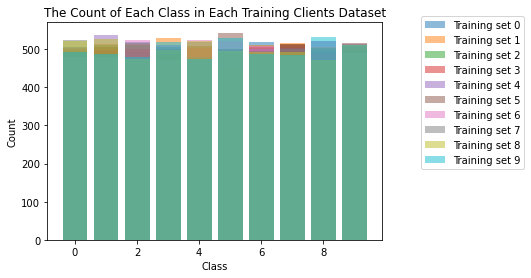

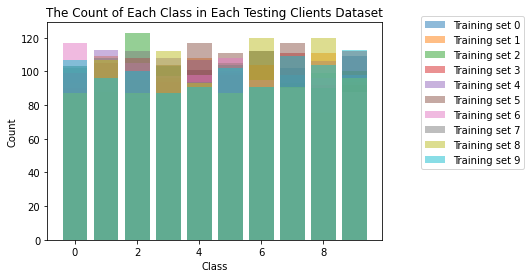

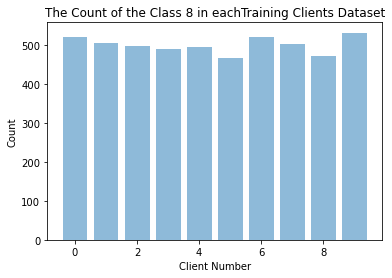

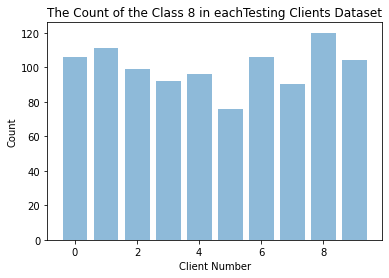

In [59]:
plottingDataSets(y_train_clients, "Training")
plottingDataSets(y_test_clients, "Testing")
c = np.random.choice(clients)
plottingFreq(y_train_clients, "Training", c)
plottingFreq(y_test_clients, "Testing", c)

Lets build a similar model instead aggregation gradients

In [60]:
def McMahanFedSGD(models_,fedModel,numClients,l):
    #setup an array to hold the weights and a null array to hold the summation of weights in the federated system
    layersNums = [0,2,4,5]    
    fedModelWeights = []
    mmSum = []
    for i in layersNums:
        fedModelWeights.append(fedModel.layers[i].weights)
        mmSum.append(fedModel.layers[i].weights)
    
    for i in range(len(layersNums)):
        for j in range(len(models_[0].layers[layersNums[i]].weights)):
            mmSum[i][j] = mmSum[i][j]*0
    
    #Perform the summation
    for n in range(0,numClients):
        count = 0
        for i in layersNums:
            for j in range(len(models_[0].layers[i].weights)):
                mmSum[count][j] = models_[n].layers[i].weights[j] - fedModelWeights[count][j]
            count += 1
    
    #find the new global models parameters
    count = 0
    for i in layersNums:
        for j in range(len(models_[0].layers[i].weights)):
            mmSum[count][j] = (l/numClients)*mmSum[count][j]
            fedModelWeights[count][j] = fedModelWeights[count][j] + mmSum[count][j]
        count += 1
    
    #Update the global model
    count = 0
    for i in layersNums:
        fedModel.layers[i].set_weights(fedModelWeights[count])
        count += 1
    return fedModel


def runIndivModelsFedGrads(numClients, noEpochs,nUpdates,bSize, writer, oLr,iLr, v):
    #create local and global models
    row = []
    fedModel = createModel(iLr)
    models = []
    for i in range(numClients):
        model = createModel(iLr)
        models.append(model)
    
    batches = np.arange(bSize)
        
    #training the CNN
    for u in range(nUpdates):
        start = timer()
        clients = np.arange(nClients)
        for i in range(nClients):
            models[i] = fedModel
        for i in range(bSize):
            b = np.random.choice(clients)
            clients = np.setdiff1d(clients,b)
            models[b].fit(x_train_clients[b], y_train_clients[b], epochs=noEpochs, verbose=v)
        fedModel = McMahanFedSGD(models,fedModel,numClients,oLr)
        #testing the CNN
        testModelsFedGrad(u,fedModel,numClients,writer,start,numClients,v,0)

    return fedModel, models

#Testing the model
def testModelsFedGrad(u,model,numClients,writer,start,NC,v,print_):
    fedAcc = 0
    row = [numClients, u+1,0,0]
    for i in range (NC):
        row.append(0)
    for i in range(numClients):
        #tesing takes place here
        loss, acc = model.evaluate(x_test_clients[i],  y_test_clients[i], verbose=v)
        fedAcc += acc/numClients
        row[4+i] = acc
    print("Accuracy at update {0} is = {1}".format(u,fedAcc))
    end = timer()
    row[2] = fedAcc
    row[3] = end-start
    #writing to .txt file
    if (print_ == 1):
        writer.writerow(row)

Probably have to test local models as soon as they are trained to get loss then get gradients

In [ ]:
#Running the model
print("Running a federated system with {0} clients, using {1} epochs per update, over {2} updates with a batch size of {3}".format(nClients,nEpochs, nUpdates,bSize))
fedModel, finalLocalModels = runIndivModelsFed(nClients, nEpochs, nUpdates,bSize, writer,outerLr,innerLr,verbose)
#Running the model using gradients
print("Running a federated system with {0} clients, using {1} epochs per update, over {2} updates with a batch size of {3}".format(nClients,nEpochs, nUpdates,bSize))
fedModel, finalLocalModels = runIndivModelsFedgrads(nClients, nEpochs, nUpdates,bSize, writer,outerLr,innerLr,verbose)